In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
#import pandas

Using TensorFlow backend.


In [2]:
t=time.time()
train_data = np.array(list(np.loadtxt("train1.csv", delimiter=","))).astype("float32")
train_labels = np.array(list(np.loadtxt("train_label.csv", delimiter=","))).astype("float32")
eval_data = np.array(list(np.loadtxt("eval1.csv", delimiter=","))).astype("float32")
eval_labels = np.array(list(np.loadtxt("eval_label.csv", delimiter=","))).astype("float32")

#eval_data = pandas.read_csv("eval.csv", delimiter=",",header=None,dtype='float32')
#eval_labels = pandas.read_csv("eval_label.csv", delimiter=",",header=None,dtype='float32')
print(time.time()-t)

129.45397329330444


In [3]:
t=time.time()
test_data = np.array(list(np.loadtxt("PureH_test.csv", delimiter=","))).astype("float32")
test_labels = np.array(list(np.loadtxt("PureH_test_label.csv", delimiter=","))).astype("float32")
print(np.shape(test_data),np.shape(test_labels))
print(time.time()-t)

(20, 1728) (20, 4)
0.516594648361206


In [4]:
x_train = train_data.reshape(-1, 24,24,1)
x_val = eval_data.reshape(-1, 24,24,1)
x_test = np.reshape(test_data.reshape(-1, 24,24,3)[:,:,:,2],(-1,24,24,1))

In [5]:
y_train=np.abs(np.reshape(train_labels,(-1,4)))
y_val=np.abs(np.reshape(eval_labels,(-1,4)))
y_test=np.abs(np.reshape(test_labels,(-1,4)))

In [6]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (6, 6), activation='relu', input_shape = (24, 24, 1)))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.5))

model.add(Dense(4, activation='sigmoid'))

In [7]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4))#, metrics=["accuracy"]) #binary_crossentropy

In [8]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [9]:
hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val, y_val), #For speed
                           callbacks=[annealer])

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
 - 65s - loss: 0.0197 - val_loss: 0.0064
Epoch 2/10
 - 56s - loss: 0.0057 - val_loss: 0.0048
Epoch 3/10
 - 93s - loss: 0.0048 - val_loss: 0.0033
Epoch 4/10
 - 67s - loss: 0.0045 - val_loss: 0.0041
Epoch 5/10
 - 75s - loss: 0.0042 - val_loss: 0.0035
Epoch 6/10
 - 77s - loss: 0.0041 - val_loss: 0.0036
Epoch 7/10
 - 96s - loss: 0.0039 - val_loss: 0.0041
Epoch 8/10
 - 97s - loss: 0.0038 - val_loss: 0.0036
Epoch 9/10
 - 118s - loss: 0.0038 - val_loss: 0.0031
Epoch 10/10
 - 138s - loss: 0.0036 - val_loss: 0.0032


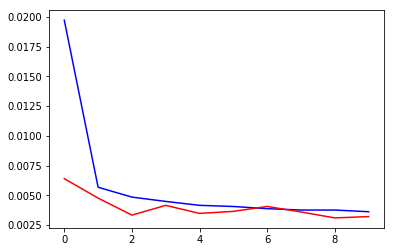

In [10]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [11]:
y_hat = model.predict(x_val)

In [12]:
(np.sum((y_val-y_hat)**2,axis=0)/(20*20*40))**0.5

array([0.07043751, 0.03617762, 0.05250481, 0.06161695], dtype=float32)

In [13]:
W=model.get_weights()

In [14]:
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    print(g)
    print(np.shape(h))

{'name': 'conv2d_1', 'trainable': True, 'batch_input_shape': (None, 24, 24, 1), 'dtype': 'float32', 'filters': 16, 'kernel_size': (6, 6), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(2,)
{'name': 'batch_normalization_1', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}

In [15]:
for i in range(18):
    print(np.shape(W[i]))

(6, 6, 1, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(3, 3, 16, 32)
(32,)
(32,)
(32,)
(32,)
(32,)
(288, 512)
(512,)
(512, 1024)
(1024,)
(1024, 4)
(4,)


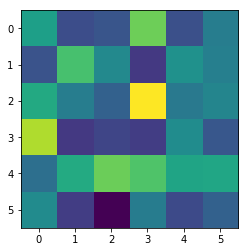

In [16]:
plt.imshow(W[0][:,:,0,0])
plt.show()

In [17]:
np.savetxt('Weight.csv',np.reshape(W[0],(1,-1)),delimiter=',')

In [18]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [19]:
print(K.learning_phase())
for i in range(16):
    print(outputs[i])

Tensor("batch_normalization_1/keras_learning_phase:0", shape=(), dtype=bool)
Tensor("conv2d_1/Relu:0", shape=(?, 19, 19, 16), dtype=float32)
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 19, 19, 16), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("dropout_1/cond/Merge:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("dropout_2/cond/Merge:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(?, 512), dtype=float32)
Tensor("leaky_re_lu_1/LeakyRelu:0", shape=(?, 512), dtype=float32)
Tensor("dropout_3/cond/Merge:0", shape=(?, 512), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 1024), dtype=float32)
Tensor("leaky_re_lu_2/LeakyRelu:0", shape=

In [20]:
# Testing
test = x_test[0,:,:,:][np.newaxis,...]
#test=np.random.rand(1,24,24,3)
layer_outs = [func([test, 0]) for func in functors]
#print(layer_outs)

In [21]:
for i in range(16):
    print(np.shape(layer_outs[i]))
    
np.savetxt("Out_MFM1.csv",np.reshape(layer_outs[1],-1),delimiter=',')
np.savetxt("Out_MFM2.csv",np.reshape(layer_outs[5],-1),delimiter=',')
np.savetxt("Out_MFM3.csv",np.reshape(layer_outs[8],-1),delimiter=',')
np.savetxt("Out_MFM4.csv",np.reshape(layer_outs[11],-1),delimiter=',')
np.savetxt("Out_MFM5.csv",np.reshape(layer_outs[14],-1),delimiter=',')

(1, 1, 19, 19, 16)
(1, 1, 19, 19, 16)
(1, 1, 9, 9, 16)
(1, 1, 9, 9, 16)
(1, 1, 7, 7, 32)
(1, 1, 7, 7, 32)
(1, 1, 3, 3, 32)
(1, 1, 3, 3, 32)
(1, 1, 288)
(1, 1, 512)
(1, 1, 512)
(1, 1, 512)
(1, 1, 1024)
(1, 1, 1024)
(1, 1, 1024)
(1, 1, 4)


(1, 24, 24, 1)


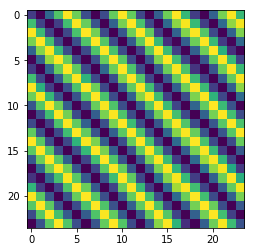

(1, 1, 19, 19, 16) 16.432995


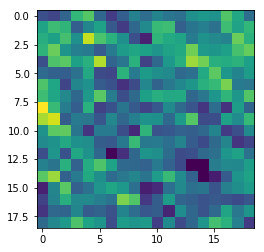

(1, 1, 19, 19, 16) 234.02863


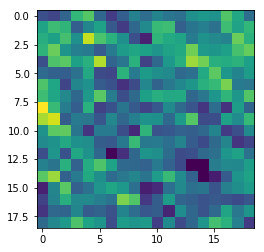

(1, 1, 9, 9, 16) 75.72714


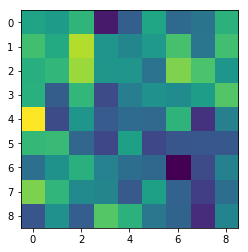

(1, 1, 9, 9, 16) 75.72714


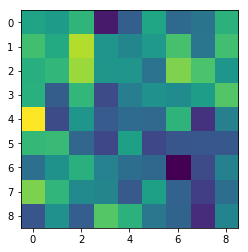

(1, 1, 7, 7, 32) 155.84712


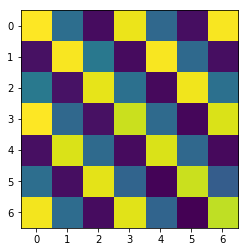

(1, 1, 7, 7, 32) 64.19071


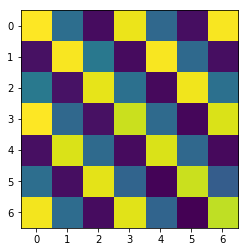

(1, 1, 3, 3, 32) 26.773947


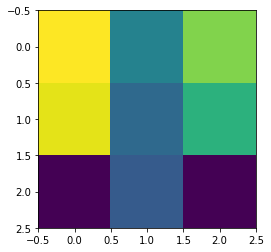

(1, 1, 3, 3, 32) 26.773947


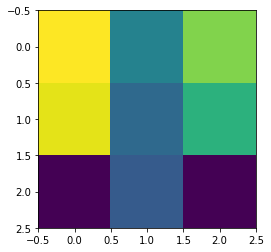

In [22]:
print(np.shape(test))
plt.imshow(test[0,:,:,0])
plt.show()
for i in range(8):
    print(np.shape(layer_outs[i]), np.sum(np.array(layer_outs[i])[0,0,:,:,0]))
    plt.imshow(np.array(layer_outs[i])[0,0,:,:,0])
    plt.show()
    


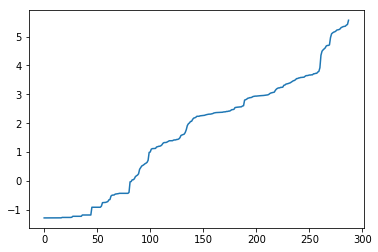

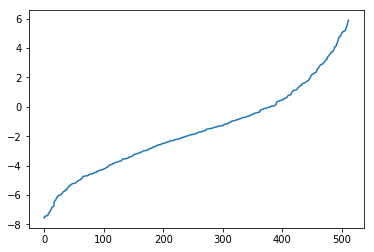

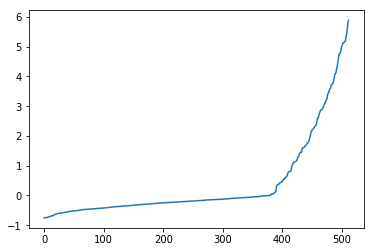

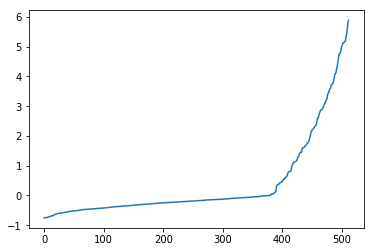

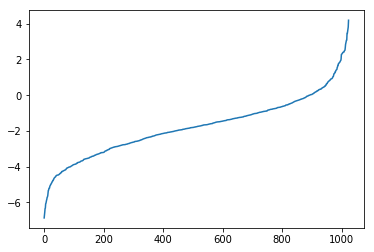

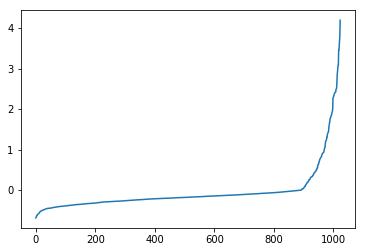

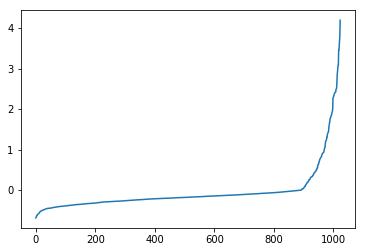

[0.00113574 0.03603848 0.10869859 0.09034824]


In [23]:
for i in range(8,15):
    plt.plot(np.sort(np.array(layer_outs[i])[0,0,:]))
    plt.show()
print(np.array(layer_outs[15])[0,0,:])

In [24]:
print(K.learning_phase())

Tensor("batch_normalization_1/keras_learning_phase:0", shape=(), dtype=bool)
